In [ ]:
''' from google.colab import drive
drive.mount('/content/gdrive') '''

" from google.colab import drive\ndrive.mount('/content/gdrive') "

In [ ]:
#!ls /content/gdrive/MyDrive/Lane_detection/


00000.jpg  00360.jpg  00720.jpg  solidWhiteRight.jpg


In [ ]:
!git clone https://github.com/JMJ-27/Lane-Detection.git

Cloning into 'Lane-Detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [ ]:
rm -r Lane-Detection/

In [ ]:
ls Lane-Detection/

00000.png  README.md  straight_road.jpg


In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [ ]:
def grayscale(img):
  # function for converting RGB into grayscale
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
  # function to use canny edge tranform
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    # function to use gaussian filter
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    # function to mask an particular section of the image from processing further
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    # function to draw lines given the points in the lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def slope_lines(image,lines):
    # function to find the parameters of the lines like slope, intercept and the edge 
    # points for drawing the line
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1
                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)
    ''' rows1, cols1 = image.shape[:2]
    y11= int(rows1)
    y22= int(rows1*0.6)
    for slope, intercept in left_lines:
        if intercept>:
          x1=int((y1-intercept)/slope)
        x22=int((y22-intercept)/slope) '''
    rows1, cols1 = image.shape[:2]
    rows1= int(rows1)
    topy= int(rows1*0.6)
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1
                if m<0:
                  if y1 > rows1:
                    borderx = (rows1-c)/m
                    bordery = rows1
                  
                  else:
                    bordery = m*0 + c
                    borderx = 0
            
                  topx=int((topy-c)/m)
                  draw_lines(img, np.array([[[int(borderx),int(bordery),int(topx),int(topy)]]]))
                
                else:
                  xintercept = x1/(1-(y1/c))
                  if xintercept > cols1:
                    bordery = m*rows1+c + rows1
                    borderx = rows1
                  
                  else:
                    borderx = (rows1-c)/m
                    bordery = 0 + rows1
                    
                  topx=int((topy-c)/m)
                  draw_lines(img, np.array([[[int(borderx),int(bordery),int(topx),int(topy)]]]))


    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)
        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        #draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    #cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    # Function to perform Hough Transformation     
    # Returns an image with hough lines drawn.
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

In [ ]:
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0, rows]
    top_left     = [cols*0, rows*0.6]
    bottom_right = [cols, rows]
    top_right    = [cols, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [ ]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
# Main pipeline function that drives all the other sub function related to image processing

    #plt.figure(1,figsize=(20,10))
    #plt.subplot(7,2,1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.show()
    #Grayscale
    gray_img = grayscale(image)
    #plt.subplot(7,2,2)
    plt.imshow(gray_img)
    plt.title("Gray Image")
    plt.show()
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #plt.subplot(7,2,3)
    plt.imshow(smoothed_img)
    plt.title("Smoothed Image")
    plt.show()
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #plt.subplot(7,2,4)
    plt.imshow(canny_img)
    plt.title("Canny Image")
    plt.show()
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #plt.subplot(7,2,5)
    plt.imshow(masked_img)
    plt.title("Masked Image")
    plt.show()
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #plt.subplot(7,2,6)
    plt.imshow(houghed_lines)
    plt.title("Hough Transformed Image")
    plt.show()
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    #plt.subplot(7,2,7)
    plt.imshow(output)
    plt.title("Output Image")
    plt.show()
    return output

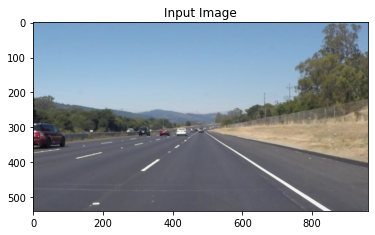

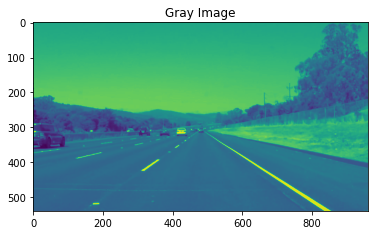

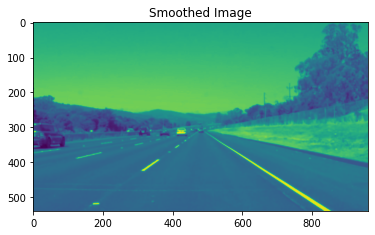

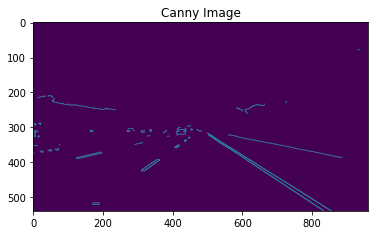

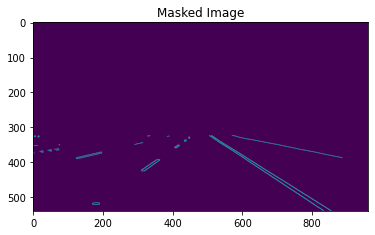

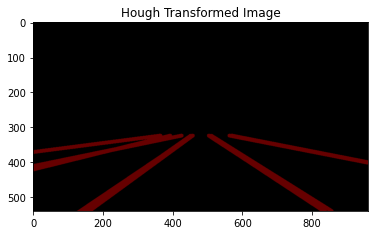

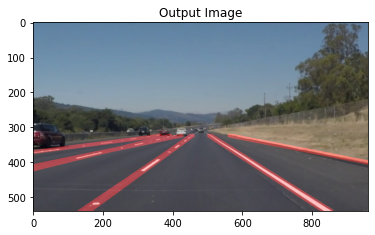

In [ ]:
# Feeding CV pipeline with image of road with consistant lane markings and little traffic
image = mpimg.imread('Lane-Detection/straight_road.jpg')
output = lane_finding_pipeline(image)


When we try the model with image of road with busy traffic and structures, it fails to process necessary steps to produce the outputs as shown below. We expects an error while performing Hough transformation,

This image contains a lot of occulusions and complex structures on the road which makes it hard to predict the road lanes.
Hough Transformation cannot be formed with the current model hence, it results in an error.


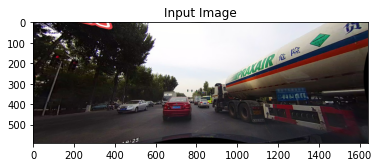

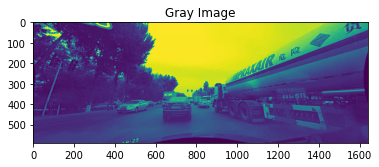

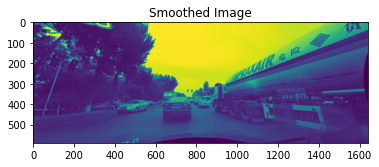

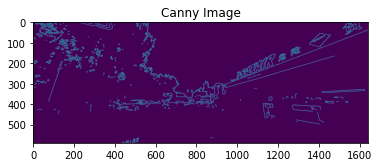

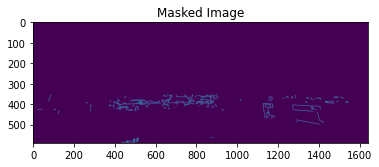

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


OverflowError: ignored

In [ ]:
# Feeding CV pipeline with image of road with inconsistant lane markings and busy traffic
image = mpimg.imread(r'./gdrive/MyDrive/Lane_detection/00000.jpg')
print("This image contains a lot of occulusions and complex structures on the road which makes it hard to predict the road lanes.")
print("Hough Transformation cannot be formed with the current model hence, it results in an error.")
output = lane_finding_pipeline(image)